# Prediction

In [1]:
# ===============================
# Imports and Setup
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    roc_curve, precision_recall_curve, average_precision_score
)

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import Loss
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras import backend as K

# ===============================
# Custom Loss and Metric Definitions
# ===============================
@register_keras_serializable()
class BinaryFocalLoss(Loss):
    """Custom focal loss function for handling class imbalance."""
    def __init__(self, gamma=2.0, alpha=0.7, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(self.alpha * K.pow(1. - pt_1, self.gamma) * K.log(pt_1)) \
               -K.mean((1 - self.alpha) * K.pow(pt_0, self.gamma) * K.log(1. - pt_0))

    def get_config(self):
        return {"gamma": self.gamma, "alpha": self.alpha}

@register_keras_serializable()
class F1Score(tf.keras.metrics.Metric):
    """Custom F1 Score metric for evaluation."""
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.tp = self.add_weight(name='tp', initializer='zeros')
        self.fp = self.add_weight(name='fp', initializer='zeros')
        self.fn = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_bin = tf.cast(y_pred > self.threshold, tf.float32)
        y_true = tf.cast(y_true, tf.float32)
        self.tp.assign_add(tf.reduce_sum(y_true * y_pred_bin))
        self.fp.assign_add(tf.reduce_sum((1 - y_true) * y_pred_bin))
        self.fn.assign_add(tf.reduce_sum(y_true * (1 - y_pred_bin)))

    def result(self):
        precision = self.tp / (self.tp + self.fp + 1e-8)
        recall = self.tp / (self.tp + self.fn + 1e-8)
        return 2 * precision * recall / (precision + recall + 1e-8)

    def reset_states(self):
        self.tp.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)

    def get_config(self):
        return {'threshold': self.threshold}

# ===============================
# Load Model and Scaler
# ===============================
model = load_model(
    "../output/model/nn_best_model.keras",
    custom_objects={"F1Score": F1Score}
)
scaler = joblib.load("../output/model/scaler.pkl")

# ===============================
# Load and Prepare Test Data
# ===============================
df_test = pd.read_parquet("../data/test_data.parquet")
print(f"Test data shape: {df_test.shape}")

X_test = df_test.drop(columns=["case_id", "date_decision", "target"])
y_true = df_test["target"].astype(np.float32)

X_test_scaled = scaler.transform(X_test).astype(np.float32)

# ===============================
# Make Predictions
# ===============================
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.518).astype("int")  # threshold determined via earlier tuning

2025-05-04 09:05:00.597578: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/yuanyishan/.pyenv/versions/3.12.3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Test data shape: (10000, 63)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


# Analysis

Accuracy:  0.7459
Precision: 0.0279
Recall:    0.7200
F1 Score:  0.0536
AUC:       0.8194


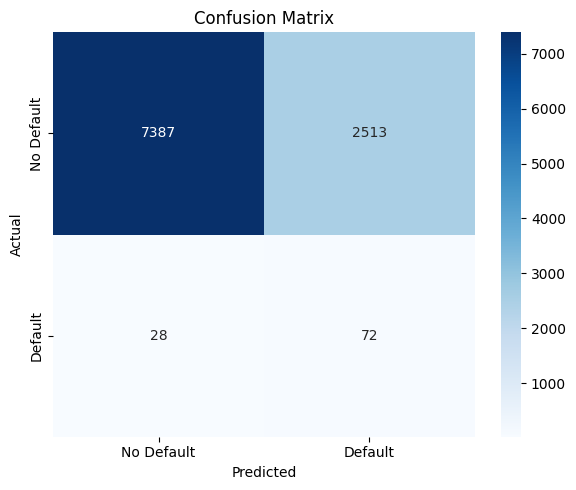

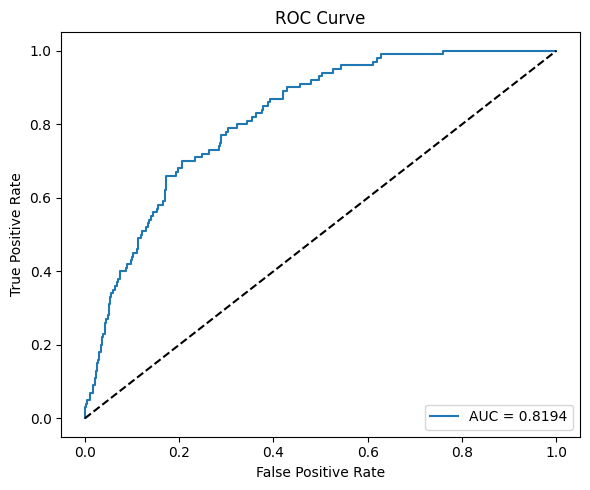


PR AUC = 0.0526
Best threshold (by F1): 0.6110


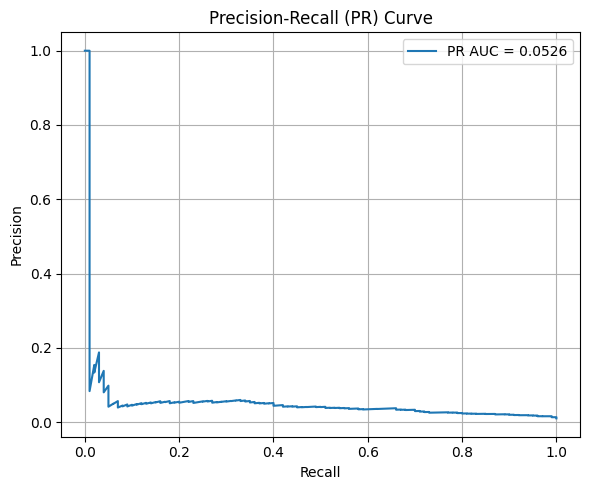

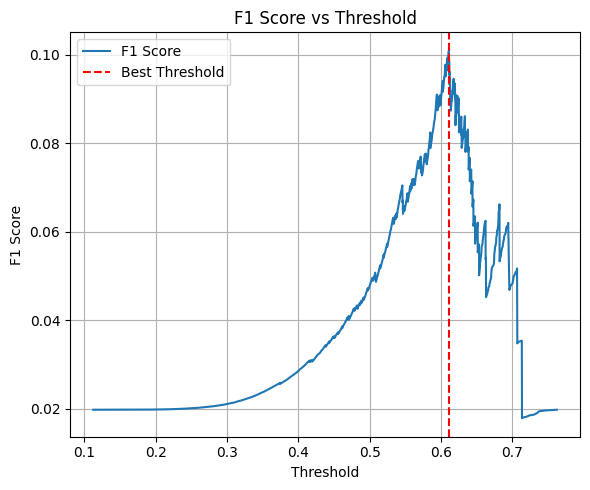

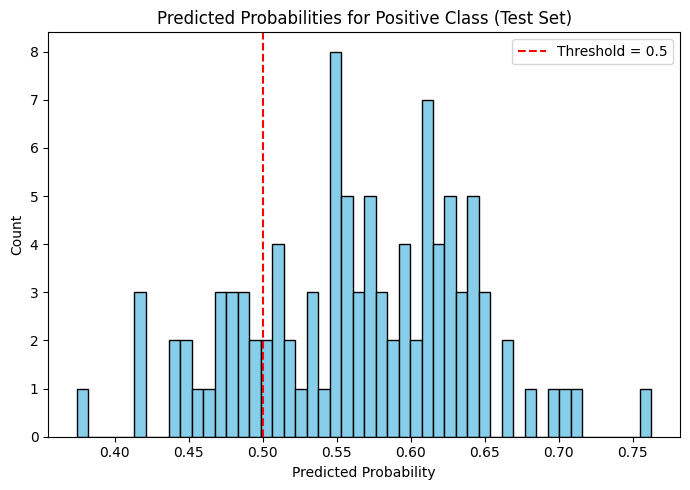

In [2]:
# ===============================
# Print Evaluation Metrics
# ===============================
print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
print(f"Precision: {precision_score(y_true, y_pred):.4f}")
print(f"Recall:    {recall_score(y_true, y_pred):.4f}")
print(f"F1 Score:  {f1_score(y_true, y_pred):.4f}")
print(f"AUC:       {roc_auc_score(y_true, y_pred_prob):.4f}")

# ===============================
# Confusion Matrix Visualization
# ===============================
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ===============================
# ROC Curve Plot
# ===============================
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_true, y_pred_prob):.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# ===============================
# Precision-Recall Curve and Best F1 Threshold
# ===============================
precision, recall, thresholds = precision_recall_curve(y_true, y_pred_prob)
f1_scores = 2 * precision * recall / (precision + recall + 1e-8)
pr_auc = average_precision_score(y_true, y_pred_prob)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"\nPR AUC = {pr_auc:.4f}")
print(f"Best threshold (by F1): {best_threshold:.4f}")

# PR Curve
plt.figure(figsize=(6, 5))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall (PR) Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# F1 Score vs Threshold Plot
plt.figure(figsize=(6, 5))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')
plt.axvline(best_threshold, color='red', linestyle='--', label='Best Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ===============================
# Distribution of Positive Class Probabilities
# ===============================
pos_probs_test = y_pred_prob[y_true == 1]

plt.figure(figsize=(7, 5))
plt.hist(pos_probs_test, bins=50, color='skyblue', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold = 0.5')
plt.title("Predicted Probabilities for Positive Class (Test Set)")
plt.xlabel("Predicted Probability")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
# ===============================
# Save results to csv
# ===============================

df_preds = pd.DataFrame({
    "case_id": df_test["case_id"].values,
    "score": y_pred_prob.flatten(),          
    "predicted_label": y_pred.flatten(),       
    "actual_label": y_true.values              
})

df_preds.to_csv("../result/submission_neural_network.csv", index=False)